In [77]:
import casadi as ca
import numpy as np
import pandas as pd
from pytope import Polytope
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


In [78]:
low_bound_control  = (-4, -4)
up_bound_control   = (5,   4)
U_SV_Poly = Polytope(lb = low_bound_control, ub = up_bound_control)
H = U_SV_Poly.A 
h = U_SV_Poly.b
nv = np.size(H, 0)
nu = np.size(H, 1)
N_Sam = 20

print(f"size of nv = {nv}")
print(f"size of nu = {nu}")

size of nv = 4
size of nu = 2


In [79]:
random_vals = np.random.uniform(-1, 1, size=(nu,N_Sam))
print(random_vals)
print(random_vals.shape)

[[ 0.55378732 -0.67705848 -0.9607009  -0.23703543 -0.92390963  0.39082865
   0.64578799 -0.88652051 -0.65151359 -0.54962169 -0.17406367 -0.18603231
   0.22419882 -0.08071786 -0.32482295 -0.70848422  0.74993743  0.12610776
  -0.08427028 -0.30992512]
 [-0.6218929  -0.76586508 -0.05868286  0.37655544 -0.63604198  0.92944823
   0.86317827 -0.69373595  0.66259343 -0.74676198  0.37888716 -0.36091462
   0.08804527  0.05501486 -0.66219344 -0.93586946  0.07452578 -0.072876
   0.68395715 -0.03194565]]
(2, 20)


In [80]:
data_id = "08"
background_filepath = f"./data/{data_id}_background.png"
recordingMeta_filepath = f"./data/{data_id}_recordingMeta.csv"
tracks_filepath = f"./data/{data_id}_tracks.csv"
tracksMeta_filepath = f"./data/{data_id}_tracksMeta.csv"

In [81]:
tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == 14]
xAcc = filtered_data['xAcceleration'].to_numpy()
yAcc = filtered_data['yAcceleration'].to_numpy()
random_vals = np.vstack((xAcc,yAcc))
print(random_vals.shape)
N_Sam = random_vals.shape[1]

(2, 494)


In [82]:
def opti_LP(H):    
    opti = ca.Opti()

    rho = opti.variable()
    theta = opti.variable(nv,1)
    y = opti.variable(nu,1)

    samples = opti.parameter(nu, N_Sam)

    opti.minimize(rho + np.ones((1, nv))@theta)

    for i in range(N_Sam):
        opti.subject_to(H @ samples[:, i]-H @ y <= theta)

    opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
    opti.subject_to(opti.bounded(0, theta, 1))
    opti.subject_to(opti.bounded(0, rho, 1))
    opti.subject_to(theta <= rho@np.ones((nv,1)))

    opts = {"ipopt.print_level": 0, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f', [samples], [theta, y, rho]) 

In [83]:
f = opti_LP(H)
theta_hat, y_hat, rho_hat = f(random_vals)
print(theta_hat,y_hat,rho_hat)
U_hat_polytope = Polytope(H, theta_hat)+y_hat
print(U_hat_polytope.H)

[1.67663, 3.18585, 4.40269, 1.93251] [-5.18764e-18, 4.74804e-18] 1
[[-1.         -0.          1.6766252 ]
 [-0.         -1.          3.18585402]
 [ 1.          0.          4.40269241]
 [ 0.          1.          1.93251412]]


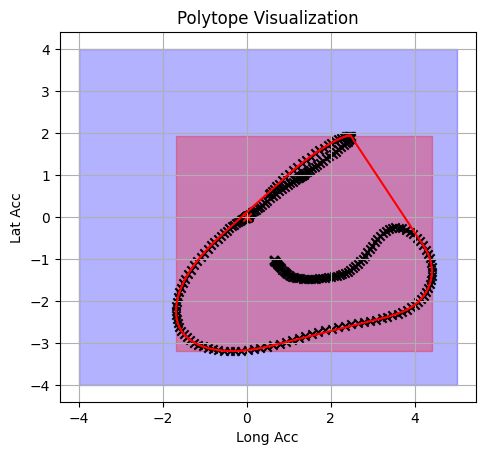

In [84]:
plt.figure()
#original polytope
U_SV_Poly.plot(color = 'b', alpha = 0.3)

#U_hat polytope
U_hat_polytope.plot(color = 'r', alpha = 0.3)

#sample points
plt.scatter(random_vals[0,:],random_vals[1,:],marker='x',color = 'black')

#y
y_s_coodinate = np.array(y_hat)
plt.scatter(y_s_coodinate[0], y_s_coodinate[1], marker='x',color='red')

#convexhull
points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Polytope Visualization")
plt.xlabel("Long Acc")
plt.ylabel("Lat Acc")
plt.grid(True)
plt.show()

In [85]:
# Radius of the octagon
radius = 6

# Number of vertices
num_vertices = 10

# Generate the vertex coordinates
angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)  # Divide circle into 8 parts
x_coords = radius * np.cos(angles)
y_coords = radius * np.sin(angles)

# Combine x and y coordinates
vertices = np.column_stack((x_coords, y_coords))

In [86]:
U_SV_Poly = Polytope(vertices)
H = U_SV_Poly.A 
h = U_SV_Poly.b
nv = np.size(H, 0)
nu = np.size(H, 1)
for i in range(nv):
    H[i,:] /= h[i]
h = np.ones_like(h)

print(f"size of nv = {nv}")
print(f"size of nu = {nu}")

size of nv = 10
size of nu = 2


In [87]:
f = opti_LP(H)
theta_hat, y_hat, rho_hat = f(random_vals)
print(theta_hat,y_hat,rho_hat)
U_hat_polytope = Polytope(H, theta_hat)+y_hat

[0.554334, 0.554334, 0.434042, 0.52511, 0.529183, 0.554334, 0.373713, 0.527907, 0.428719, 0.321984] [1.20825, -1.05987] 0.554334


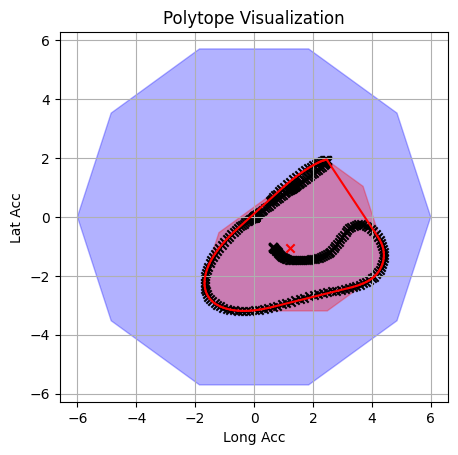

In [88]:
plt.figure()
#original polytope
U_SV_Poly.plot(color = 'b', alpha = 0.3)

#U_hat polytope
U_hat_polytope.plot(color = 'r', alpha = 0.3)

#sample points
plt.scatter(random_vals[0,:],random_vals[1,:],marker='x',color = 'black')

#y
y_s_coodinate = np.array(y_hat)
plt.scatter(y_s_coodinate[0], y_s_coodinate[1], marker='x',color='red')

#convexhull
points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Polytope Visualization")
plt.xlabel("Long Acc")
plt.ylabel("Lat Acc")
plt.grid(True)
plt.show()

## Moving Horizon Method ##

In [89]:
mh_window_size = 50

In [90]:
def opti_LP_mh(H,mh_window_size):    
    opti = ca.Opti()

    rho = opti.variable()
    theta = opti.variable(nv,1)
    y = opti.variable(nu,1)

    samples = opti.parameter(nu, mh_window_size)

    opti.minimize(rho + np.ones((1, nv))@theta)

    for i in range(mh_window_size):
        opti.subject_to(H @ samples[:, i]-H @ y <= theta)

    opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
    opti.subject_to(opti.bounded(0, theta, 1))
    opti.subject_to(opti.bounded(0, rho, 1))
    opti.subject_to(theta <= rho@np.ones((nv,1)))

    opts = {"ipopt.print_level": 0, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f', [samples], [theta, y, rho]) 

In [91]:
U_SV_Poly = Polytope(vertices)
H = U_SV_Poly.A 
h = U_SV_Poly.b
nv = np.size(H, 0)
nu = np.size(H, 1)
for i in range(nv):
    H[i,:] /= h[i]
h = np.ones_like(h)

f_mh = opti_LP_mh(H,mh_window_size)

print(f"size of nv = {nv}")
print(f"size of nu = {nu}")

size of nv = 10
size of nu = 2


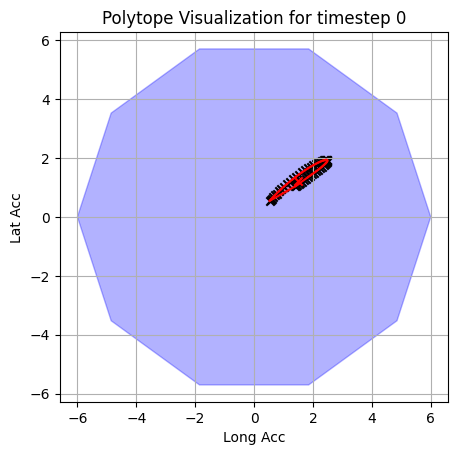

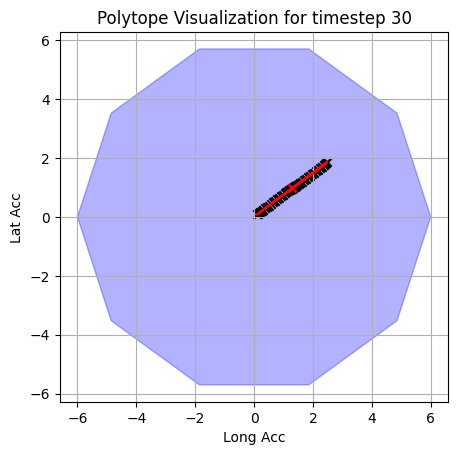

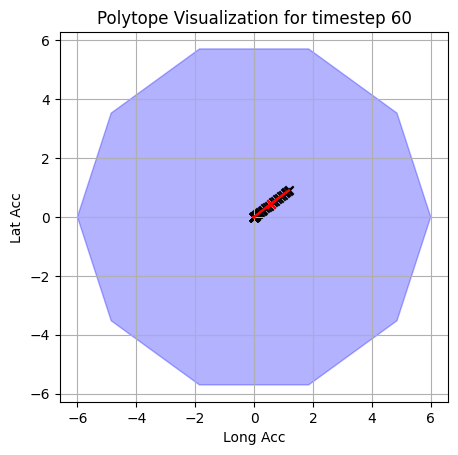

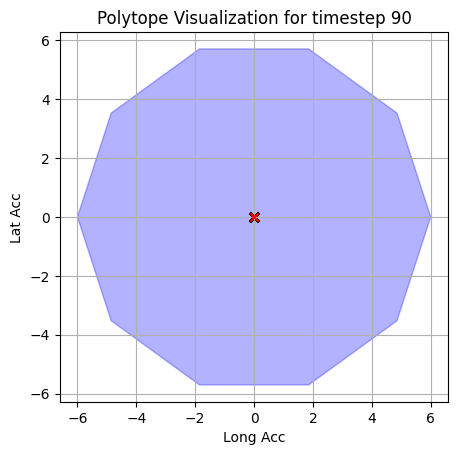

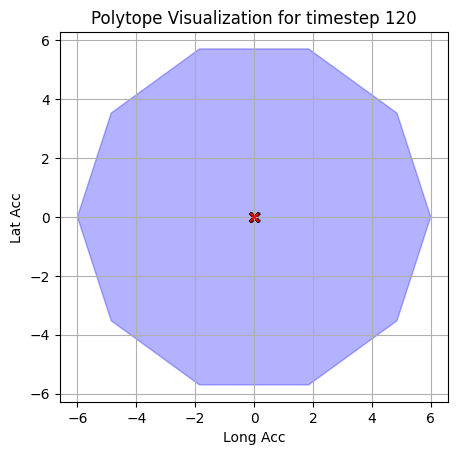

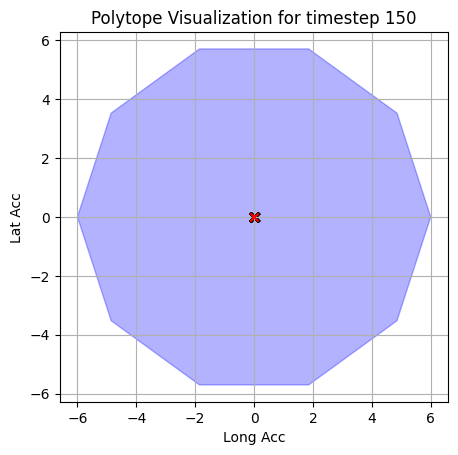

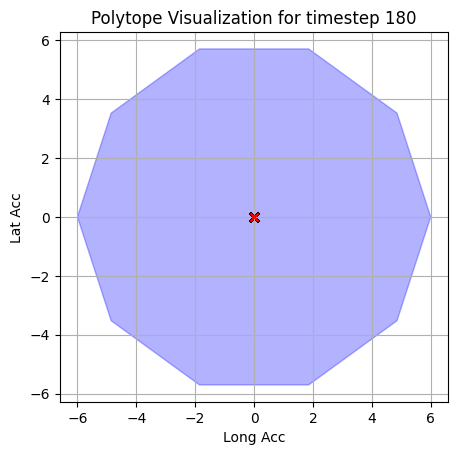

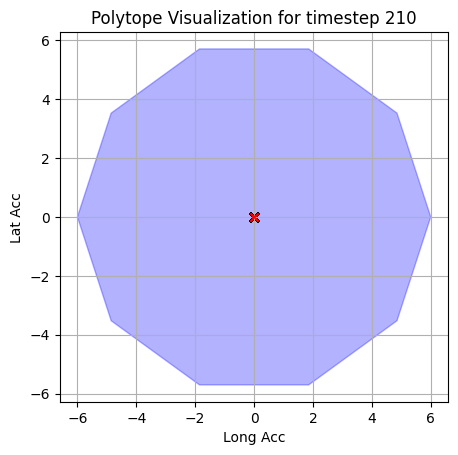

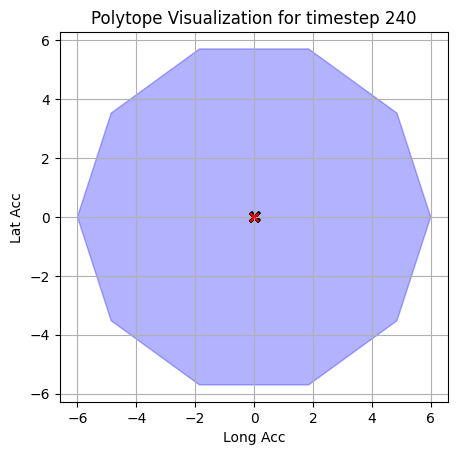

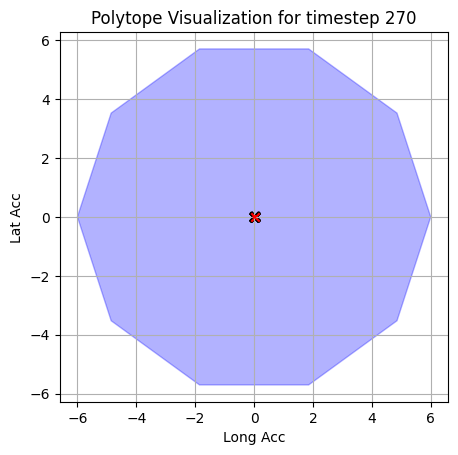

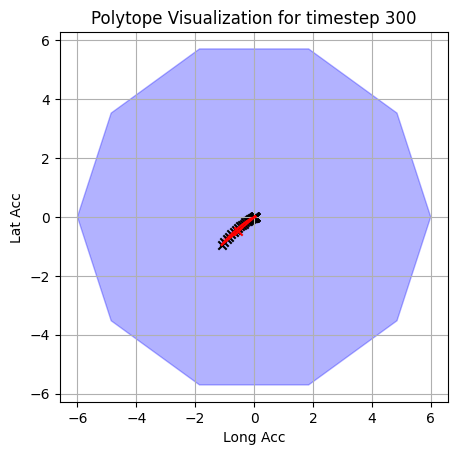

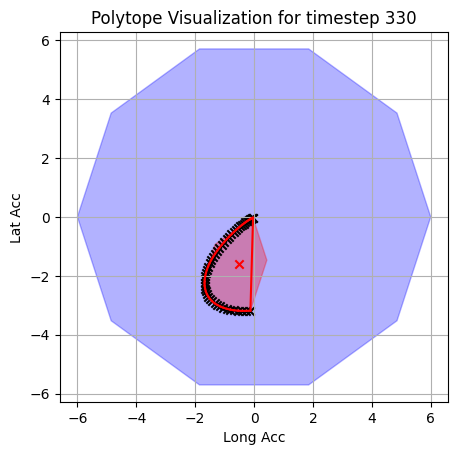

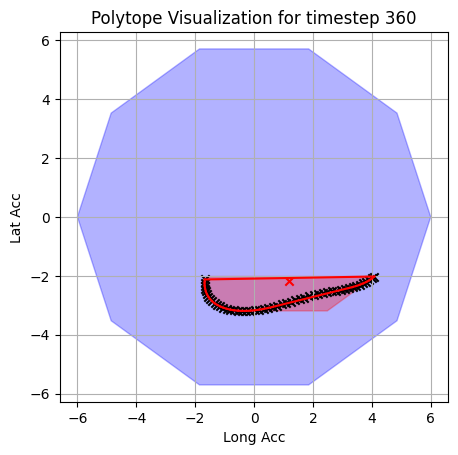

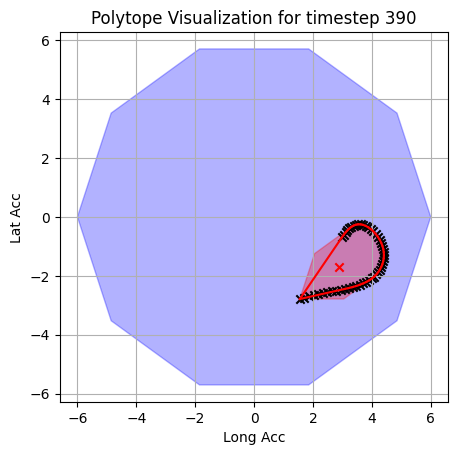

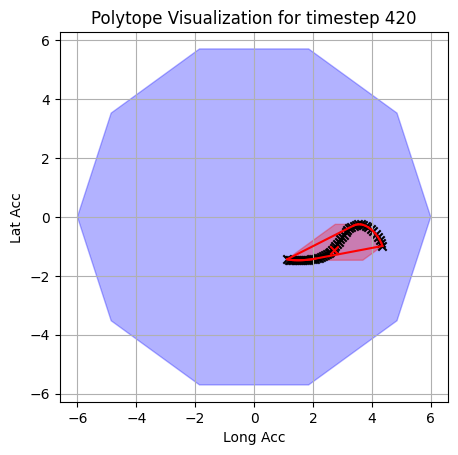

In [92]:
for i in range(N_Sam-mh_window_size):
    if(i%30 == 0):
        theta_hat, y_hat, rho_hat = f_mh(random_vals[:,i:i+mh_window_size])
        U_hat_polytope = Polytope(H, theta_hat)+y_hat
        
        #original polytope
        U_SV_Poly.plot(color = 'b', alpha = 0.3)

        #U_hat polytope
        U_hat_polytope.plot(color = 'r', alpha = 0.3)

        #sample points
        plt.scatter(random_vals[0,i:i+mh_window_size],random_vals[1,i:i+mh_window_size],marker='x',color = 'black')

        #y
        y_s_coodinate = np.array(y_hat)
        plt.scatter(y_s_coodinate[0], y_s_coodinate[1], marker='x',color='red')

        #convexhull
        points = random_vals[:,i:i+mh_window_size].T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

        plt.gca().set_aspect('equal', adjustable='box')
        plt.title(f"Polytope Visualization for timestep {i}")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        plt.show()

## Online Recursive Method ##

In [93]:
def opti_LP_OR(H):    
    opti = ca.Opti()

    rho = opti.variable()
    theta = opti.variable(nv,1)
    y = opti.variable(nu,1)

    samples = opti.parameter(nu, 1)
    y_pre = opti.parameter(nu,1)
    theta_pre = opti.parameter(nv,1)

    opti.minimize(rho + np.ones((1, nv))@theta)

    opti.subject_to(H @ samples-H @ y <= theta)
    opti.subject_to(H @ y_pre + theta_pre <= H @ y + theta)
    opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
    opti.subject_to(opti.bounded(0, theta, 1))
    opti.subject_to(opti.bounded(0, rho, 1))
    opti.subject_to(theta <= rho@np.ones((nv,1)))

    opts = {"ipopt.print_level": 0, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f', [samples, y_pre, theta_pre], [theta, y, rho]) 

In [94]:
U_SV_Poly = Polytope(vertices)
H = U_SV_Poly.A 
h = U_SV_Poly.b
for i in range(nv):
    H[i,:] /= h[i]
h = np.ones_like(h)

nv = np.size(H, 0)
nu = np.size(H, 1)

f_or = opti_LP_OR(H)

print(f"size of nv = {nv}")
print(f"size of nu = {nu}")

size of nv = 10
size of nu = 2


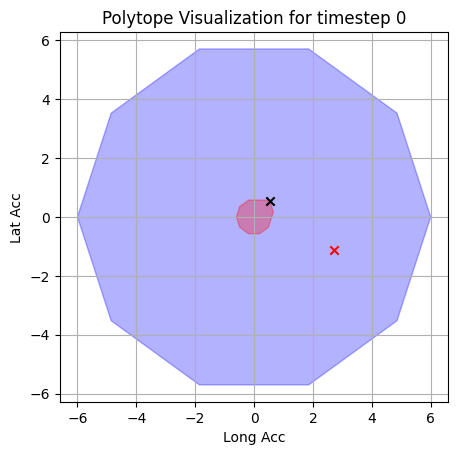

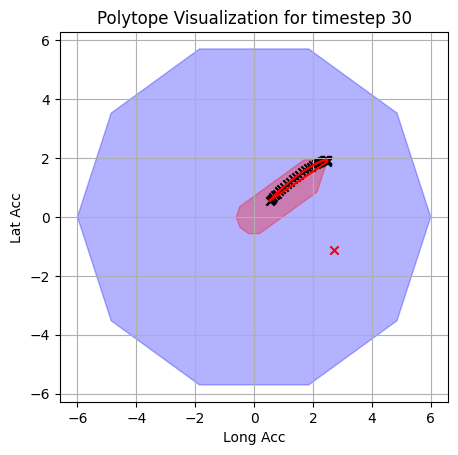

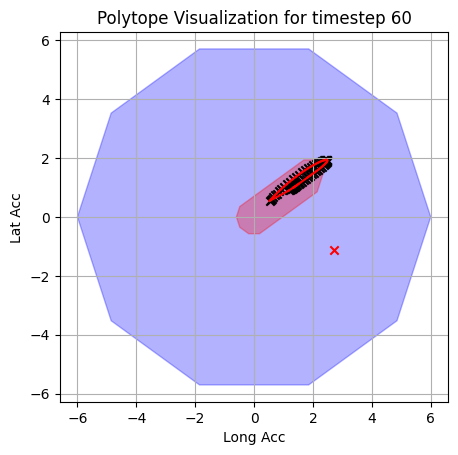

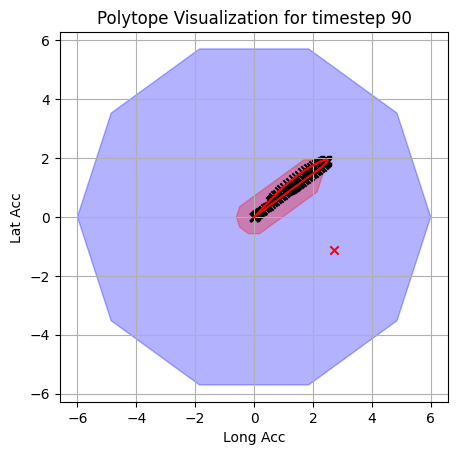

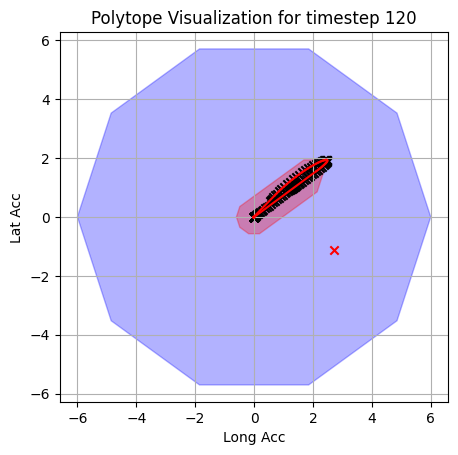

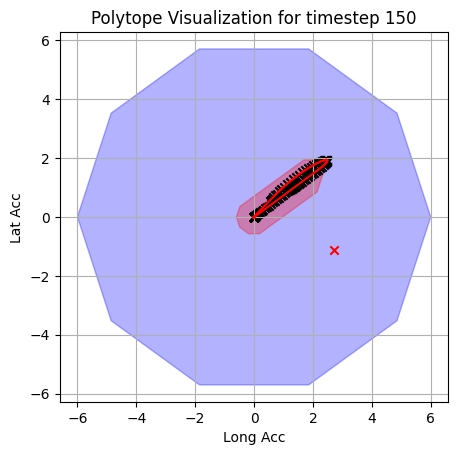

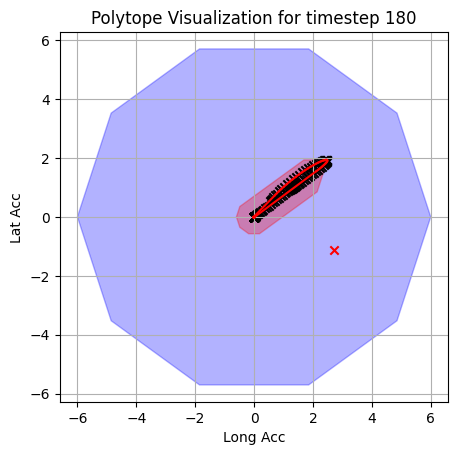

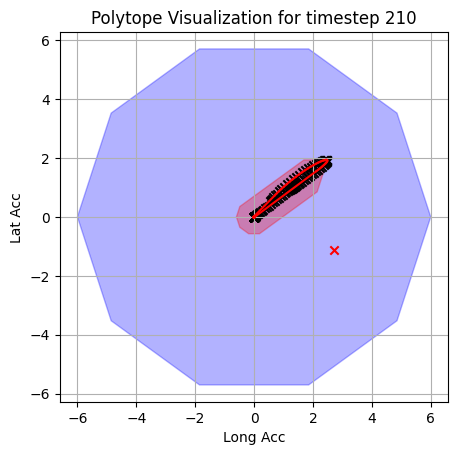

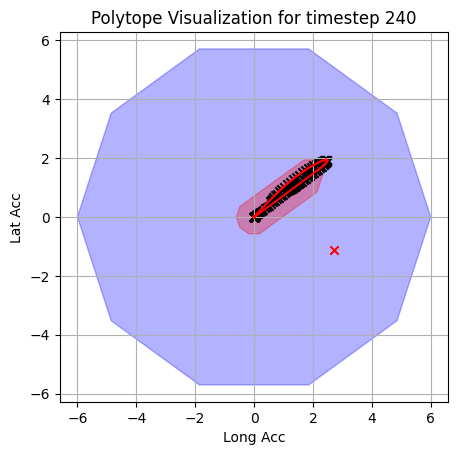

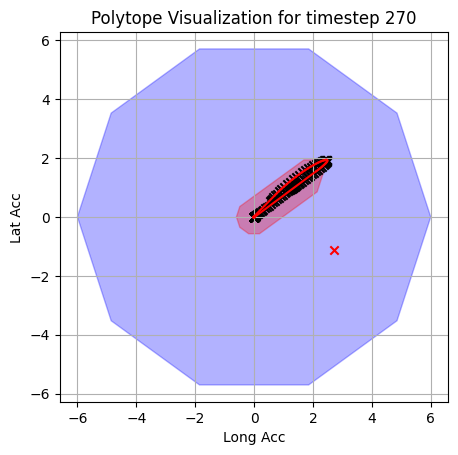

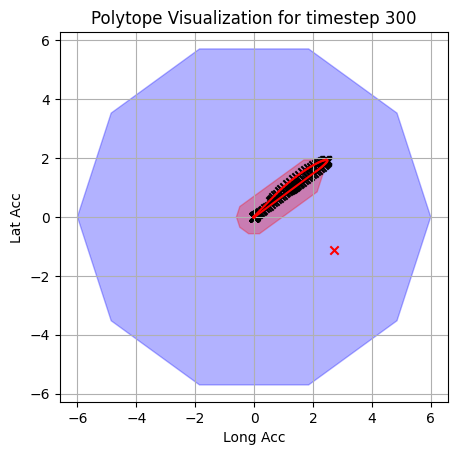

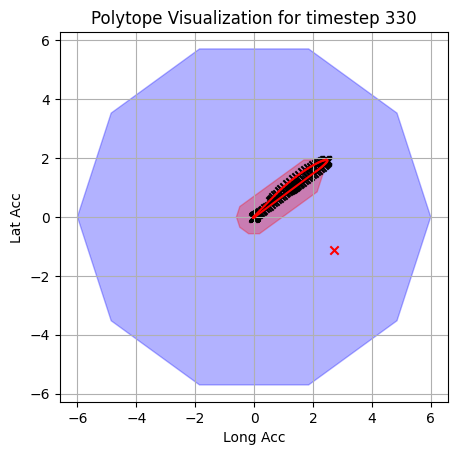

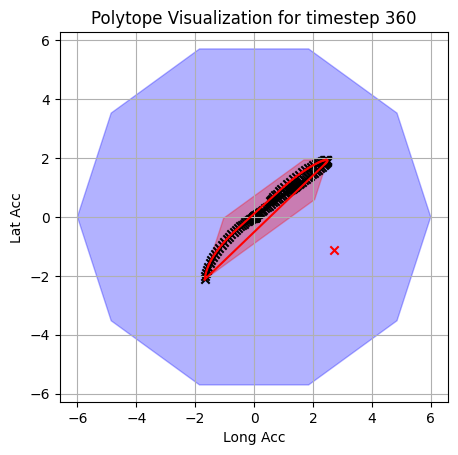

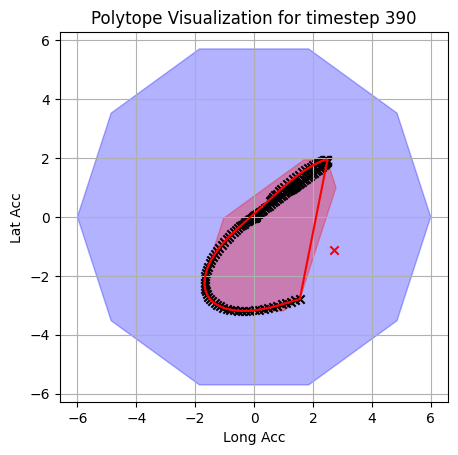

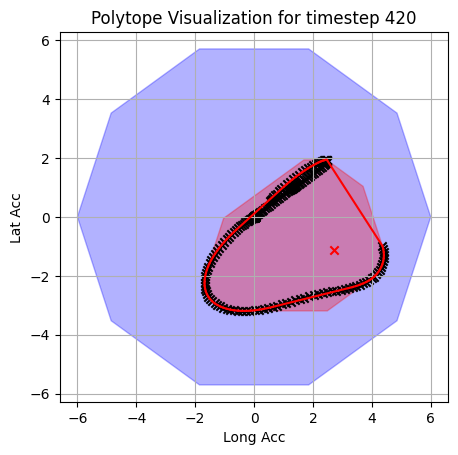

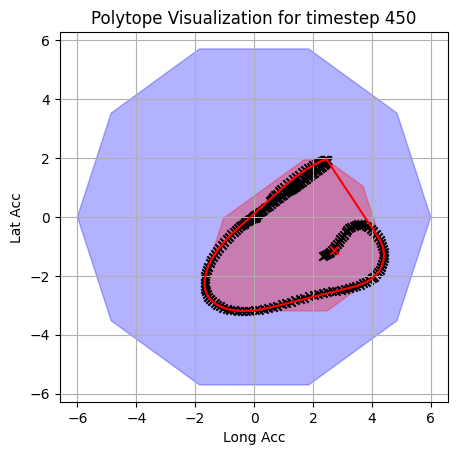

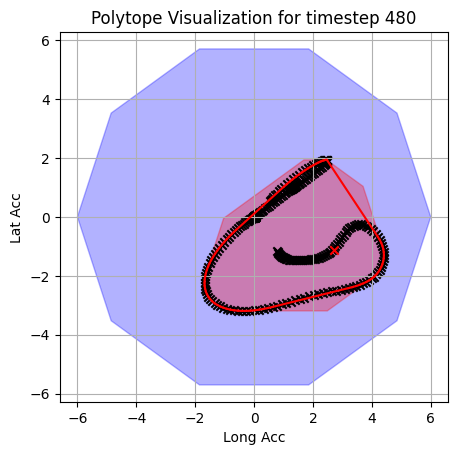

In [95]:
#initialization
theta_pre, y_pre, rho_pre = f_or(np.array([[0],[0]]),np.zeros((nu,1)),0.1*np.ones((nv,1)))

for i in range(N_Sam):
    theta_pre,y_pre,rho_pre = f_or(random_vals[:,i],y_pre,theta_pre)
    U_hat_polytope = Polytope(H, theta_pre)+y_pre

    if(i%30 == 0):
        #original polytope
        U_SV_Poly.plot(color = 'b', alpha = 0.3)

        #U_hat polytope
        U_hat_polytope.plot(color = 'r', alpha = 0.3)

        #sample points
        plt.scatter(random_vals[0,:i+1],random_vals[1,:i+1],marker='x',color = 'black')

        #y
        y_s_coodinate = np.array(y_hat)
        plt.scatter(y_s_coodinate[0], y_s_coodinate[1], marker='x',color='red')

        #convexhull
        if i > 1:
            points = random_vals[:,:i+1].T
            hull = ConvexHull(points)
            for simplex in hull.simplices:
                plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

        plt.gca().set_aspect('equal', adjustable='box')
        plt.title(f"Polytope Visualization for timestep {i}")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        plt.show()
    